In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from problem import Fokker_Planck_1d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [3]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]



In [4]:
my_prob = Fokker_Planck_1d(case=1)
sigma_SDE = my_prob.sigma_SDE
mag = my_prob.mu_mag
freq = my_prob.mu_freq


def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    t = x_pde[:,[0]]
    mu_eval = mag * torch.cos(freq * t)
    D = sigma_SDE**2 / 2


    grad_u = grad(u_pde, x_pde)
    u_t = grad_u[:, [0]]
    u_x = grad_u[:, [1]]

    u_xx = grad(u_x, x_pde)[:, [1]]

    pde_value = u_t + mu_eval*u_x - D*u_xx
    return pde_value

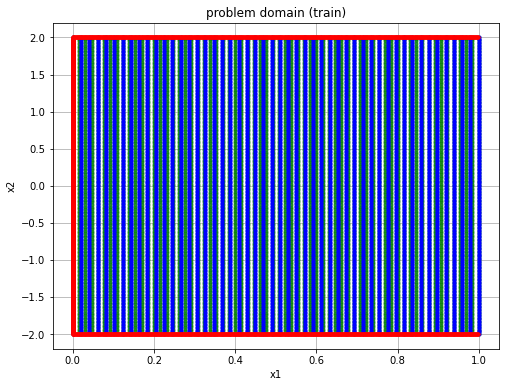

In [5]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_test = data['target_test'].item()['u']


plot_domain_2d(x_pde=x_pde, x_bd=x_bd, x_test=x_test)


In [6]:
x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_test = torch.from_numpy(target_test).float()
print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_test.shape, target_test.shape)

torch.Size([10000, 2]) torch.Size([10000, 1])
torch.Size([2998, 2]) torch.Size([2998, 1])
torch.Size([14652, 2]) torch.Size([14652, 1])


In [7]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [8]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_test = target_test.cuda()


In [9]:

def train(width):
    model  = FCNet(input_dim=2, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [10]:
width_vec = [100,250,500,750,1000]
result_all = []
for width in width_vec:
    print(width,'.....................')
    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

100 .....................
0 0.470025897026062
100 0.045539308339357376
200 0.04369032382965088
300 0.042322490364313126
400 0.04074712097644806
500 0.03886658325791359
600 0.03658546134829521
700 0.03384522348642349
800 0.030800940468907356
900 0.027918266132473946
1000 0.02561905048787594
1100 0.023882463574409485
1200 0.02246183343231678
1300 0.021254297345876694
1400 0.020262451842427254
1500 0.019462231546640396
1600 0.0188438780605793
1700 0.018373848870396614
1800 0.017995942384004593
1900 0.017660396173596382
2000 0.01733222045004368
2100 0.017088180407881737
2200 0.016808899119496346
2300 0.016464857384562492
2400 0.016041532158851624
2500 0.015548540279269218
2600 0.014994959346950054
2700 0.014385896734893322
2800 0.013725966215133667
2900 0.013022811152040958
3000 0.01229160651564598
3100 0.011556820012629032
3200 0.010847738943994045
3300 0.010191421955823898
3400 0.009607726708054543
3500 0.00910104624927044
3600 0.008660097606480122
3700 0.008265042677521706
3800 0.007894

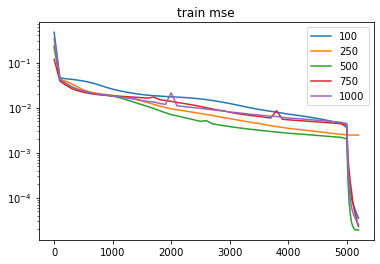

In [11]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

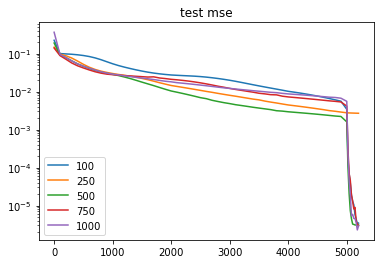

In [12]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [13]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [14]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')